In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# importar bibliotecas del sistema
import os
import time
import shutil
import pathlib
import itertools

# importar herramientas de manipulación de datos
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# importar bibliotecas de aprendizaje profundo
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignorar las advertencias
import warnings
warnings.filterwarnings("ignore")

print('módulos cargados')

módulos cargados


In [ ]:
!pip show kaggle

Name: kaggle
Version: 1.5.16
Summary: Kaggle API
Home-page: https://github.com/Kaggle/kaggle-api
Author: Kaggle
Author-email: support@kaggle.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: bleach, certifi, python-dateutil, python-slugify, requests, six, tqdm, urllib3
Required-by: 


In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jhojanroyqlop","key":"90c5b9e02859df5dba8707ce5d80c8f1"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
alphiree/cardiovascular-diseases-risk-prediction-dataset        Cardiovascular Diseases Risk Prediction Dataset       5MB  2023-07-03 12:12:19           4671        196  1.0              
nelgiriyewithana/countries-of-the-world-2023                    Global Country Information Dataset 2023              23KB  2023-07-08 20:37:33           3455        127  1.0              
arnavsmayan/netflix-userbase-dataset                            Netflix Userbase Dataset                             25KB  2023-07-04 07:38:41           4676         93  1.0              
byomokeshsenapati/spotify-song-attributes                   

In [ ]:
!kaggle --version

Kaggle API 1.5.16


In [ ]:
!pip install kaggle --quiet

In [ ]:
! kaggle datasets download -d

usage: kaggle datasets download
       [-h]
       [-f FILE_NAME]
       [-p PATH]
       [-w]
       [--unzip]
       [-o]
       [-q]
       [dataset]
kaggle datasets download: error: argument -d/--dataset: expected one argument


In [ ]:
! kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 99% 769M/778M [00:10<00:00, 100MB/s]
100% 778M/778M [00:10<00:00, 75.6MB/s]


In [ ]:
!unzip /content/covid19-radiography-database.zip -d "/content/drive/MyDrive/Simulacion Modelamiento con imagenes"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/drive/MyDrive/Simulacion Modelamiento con imagenes/COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: /content/drive/MyDrive/Simulacion Modelamiento con imagenes/COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: /content/drive/MyDrive/Simulacion Modelamiento con imagenes/COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: /content/drive/MyDrive/Simulacion Modelamiento con imagenes/COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: /content/drive/MyDrive/Simulacion Modelamiento con imagenes/COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: /content/drive/MyDrive/Simulacion Modelamiento con imagenes/COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: /content/drive/MyDrive/Simulacion Modelamiento con imagenes/COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflat

VGG19 ENTRENAMIENTO_PASO PREVIO

# *recorrer el directorio que contiene los archivos de imágenes, obtener las rutas y las almacenarlas(etiquetar) *

In [8]:
# Generar rutas de archivos con etiquetas
def definir_rutas(directorio_datos):
  rutas_archivos = []
  etiquetas = []
  carpetas = os.listdir(directorio_datos)
  for carpeta in carpetas:
      ruta_carpeta = os.path.join(directorio_datos, carpeta)
      # Verificar si hay otros archivos en el directorio principal. Si los hay, se ignoran.
      if pathlib.Path(ruta_carpeta).suffix != '':
          continue

      lista_archivos = os.listdir(ruta_carpeta)
      for archivo in lista_archivos:
          ruta_archivo = os.path.join(ruta_carpeta, archivo)

          # Verificar si hay otras carpetas
          if pathlib.Path(ruta_carpeta).suffix == '':
              # Verificar las máscaras no deseadas
              if pathlib.Path(ruta_archivo).parts[-1] == 'masks' or pathlib.Path(ruta_archivo).parts[-1] == 'Masks' or pathlib.Path(ruta_archivo).parts[-1] == 'MASKS':
                  continue

              else:
                  archivos_subcarpeta = os.listdir(ruta_archivo)
                  for archivo_subcarpeta in archivos_subcarpeta:
                      ruta_archivo_subcarpeta = os.path.join(ruta_archivo, archivo_subcarpeta)
                      rutas_archivos.append(ruta_archivo_subcarpeta)
                      etiquetas.append(carpeta)

          else:
              rutas_archivos.append(ruta_archivo)
              etiquetas.append(carpeta)

  return rutas_archivos, etiquetas


In [9]:
# Concatenar las rutas de los datos con las etiquetas en un dataframe (para luego ser ajustado en el modelo)
def definir_df(archivos, clases):
  serie_rutas = pd.Series(archivos, name='rutas_archivos')
  serie_etiquetas = pd.Series(clases, name='etiquetas')
  return pd.concat([serie_rutas, serie_etiquetas], axis=1)

In [10]:
# Dividir el dataframe en conjuntos de entrenamiento, validación y prueba
def dividir_datos(directorio_datos):
  # Obtener el dataframe de entrenamiento
  archivos, clases = definir_rutas(directorio_datos)
  df = definir_df(archivos, clases)
  etiquetas_estratificadas = df['etiquetas']
  df_entrenamiento, df_restante = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=etiquetas_estratificadas)

  # Obtener los dataframes de validación y prueba
  etiquetas_estratificadas = df_restante['etiquetas']
  df_validacion, df_prueba = train_test_split(df_restante, train_size=0.5, shuffle=True, random_state=123, stratify=etiquetas_estratificadas)

  return df_entrenamiento, df_validacion, df_prueba

VGG19 ENTRENAMIENTO

In [11]:
def crear_generadores_entrenamiento_validacion_prueba(df_entrenamiento, df_validacion, df_prueba, tam_lote):
    '''
    Esta función toma los dataframes de entrenamiento, validación y prueba, y los ajusta en generadores de datos de imágenes,
    ya que el modelo toma los datos de un generador de datos de imágenes. El generador de datos de imágenes convierte las imágenes en tensores.
    '''

    # Definir los parámetros del modelo
    tam_img = (224, 224)
    canales = 3
    color = 'rgb'
    forma_img = (tam_img[0], tam_img[1], canales)

    # Recomendado: usar una función personalizada para el tamaño del lote de datos de prueba, de lo contrario, podemos usar el tamaño de lote normal.
    longitud_prueba = len(df_prueba)

    # Calcula el tamaño óptimo del lote para el conjunto de datos de prueba.
    tam_lote_prueba = max(sorted([longitud_prueba // n for n in range(1, longitud_prueba + 1) if longitud_prueba % n == 0 and longitud_prueba / n <= 80]))

    pasos_prueba = longitud_prueba // tam_lote_prueba

    def escalar(img):
        return img

    # Utiliza la función de preprocesamiento personalizada 'escalar'.
    generador_entrenamiento = ImageDataGenerator(preprocessing_function=escalar, horizontal_flip=True)

    # Crea un generador de datos de imagen para el conjunto de validación y prueba.
    generador_validacion_prueba = ImageDataGenerator(preprocessing_function=escalar)

    # Configura el generador de datos de entrenamiento con las rutas de las imágenes, etiquetas, tamaño de imagen y tamaño de lote.
    generador_entrenamiento = generador_entrenamiento.flow_from_dataframe(df_entrenamiento, x_col='rutas_archivos', y_col='etiquetas', target_size=tam_img, class_mode='categorical',
                                           color_mode=color, shuffle=True, batch_size=tam_lote)

    # Configura el generador de datos de validación de manera similar al de entrenamiento.
    generador_validacion = generador_validacion_prueba.flow_from_dataframe(df_validacion, x_col='rutas_archivos', y_col='etiquetas', target_size=tam_img, class_mode='categorical',
                                           color_mode=color, shuffle=True, batch_size=tam_lote)

    # Configura el generador de datos de prueba. Nota que shuffle=False para mantener el orden de las muestras.
    generador_prueba = generador_validacion_prueba.flow_from_dataframe(df_prueba, x_col='rutas_archivos', y_col='etiquetas', target_size=tam_img, class_mode='categorical',
                                          color_mode=color, shuffle=False, batch_size=tam_lote_prueba)

    # Devuelve los generadores de datos de entrenamiento, validación y prueba.
    return generador_entrenamiento, generador_validacion, generador_prueba


In [12]:
def mostrar_imagenes(generador):
    '''
    Esta función toma el generador de datos y muestra una muestra de las imágenes.
    '''

    # Obtiene las clases e imágenes que se mostrarán
    diccionario_generador = generador.class_indices
    clases = list(diccionario_generador.keys())
    imagenes, etiquetas = next(generador)

    # Calcula el número de muestras a mostrar
    longitud = len(etiquetas)
    muestra = min(longitud, 25)

    plt.figure(figsize=(20, 20))

    for i in range(muestra):
        plt.subplot(5, 5, i + 1)
        imagen = imagenes[i] / 255
        plt.imshow(imagen)
        indice = np.argmax(etiquetas[i])
        nombre_clase = clases[indice]
        plt.title(nombre_clase, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()


In [ ]:
#FUNCION CALLBACK: PUEDE OPTIMIZAR , DETENER Y CONTROLAR EL ENTRENAMIENTO

In [13]:
class MiCallback(keras.callbacks.Callback):
    def __init__(self, modelo, paciencia, paciencia_para_detener, umbral, factor, lotes, epocas, preguntar_epoca):
        super(MiCallback, self).__init__()
        self.modelo = modelo
        self.paciencia = paciencia
        self.paciencia_para_detener = paciencia_para_detener
        self.umbral = umbral
        self.factor = factor
        self.lotes = lotes
        self.epocas = epocas
        self.preguntar_epoca = preguntar_epoca
        self.preguntar_epoca_inicial = preguntar_epoca

        # variables
        self.contador = 0
        self.contador_para_detener = 0
        self.mejor_epoca = 1  # época con la pérdida más baja
        self.tasa_aprendizaje_inicial = float(tf.keras.backend.get_value(modelo.optimizer.lr))
        self.prec_tr_entrenamiento_mas_alta = 0.0  # establece la precisión de entrenamiento más alta inicialmente en 0.0
        self.perd_val_mas_baja = np.inf
        self.mejores_pesos = self.modelo.get_weights()
        self.pesos_iniciales = self.modelo.get_weights()

    # Define una función que se ejecutará al comienzo del entrenamiento
    def on_train_begin(self, logs=None):
        # Pregunta al usuario si desea que el modelo solicite permiso para detener el entrenamiento
        msg = '¿Deseas que el modelo te pida que detengas el entrenamiento [s/n]?'
        print(msg)
        ans = input('')
        if ans in ['S', 's']:
            self.pedir_permiso = 1
        elif ans in ['N', 'n']:
            self.pedir_permiso = 0

        # Imprime los encabezados de las columnas para el registro de entrenamiento
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Época', 'Pérdida', 'Precisión', 'Pérdida_V', 'Precisión_V', 'LR', 'Siguiente LR', 'Monitor','% Mejora', 'Duración')
        print(msg)
        self.tiempo_inicio = time.time()

    # Define una función que se ejecutará al final del entrenamiento
    def on_train_end(self, logs=None):
        tiempo_final = time.time()
        duracion_entrenamiento = tiempo_final - self.tiempo_inicio
        # Convierte la duración a horas, minutos y segundos
        horas = duracion_entrenamiento // 3600
        minutos = (duracion_entrenamiento - (horas * 3600)) // 60
        segundos = duracion_entrenamiento - ((horas * 3600) + (minutos * 60))

        # Imprime la duración del entrenamiento en horas, minutos y segundos
        msg = f'tiempo transcurrido durante el entrenamiento: {str(horas)} horas, {minutos:4.1f} minutos, {segundos:4.2f} segundos)'
        print(msg)

        # Establece los pesos del modelo a los mejores pesos encontrados durante el entrenamiento
        self.modelo.set_weights(self.mejores_pesos)

    # Define una función que se ejecutará al final de cada lote de entrenamiento
    def on_train_batch_end(self, batch, logs=None):
        # Obtiene la precisión y la pérdida del lote actual y las multiplica por 100 para convertirlas en porcentajes
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # Imprime la precisión y la pérdida del lote actual en la misma línea
        msg = '{0:20s}procesando lote {1:} de {2:5s} - precisión= {3:5.3f} - pérdida: {4:8.5f}'.format(' ', str(batch), str(self.lotes), acc, loss)
        print(msg, '\r', end='')


    # Definimos el método que se ejecutará al final de cada época
    def on_epoch_end(self, epoch, logs=None):
        # Guarda el tiempo actual para calcular la duración de la época
        self.tiempo_final = time.time()
        duracion = self.tiempo_final - self.tiempo_inicio

        lr = float(tf.keras.backend.get_value(self.modelo.optimizer.lr)) # obtener la tasa de aprendizaje actual
        tasa_aprendizaje_actual = lr
        acc = logs.get('accuracy')
        v_acc = logs.get('val_accuracy')
        loss = logs.get('loss')
        v_loss = logs.get('val_loss')

        if acc < self.umbral:
            monitor = 'precisión'

            # Si es la primera época, establece la mejora del progreso en 0
            if epoch == 0:
                mejora_progreso = 0.0

            # De lo contrario, calcula el porcentaje de mejora en la precisión de entrenamiento en comparación con la época anterior
            else:
                mejora_progreso = (acc - self.prec_tr_entrenamiento_mas_alta) * 100 / self.prec_tr_entrenamiento_mas_alta


            if acc > self.prec_tr_entrenamiento_mas_alta:
                self.prec_tr_entrenamiento_mas_alta = acc
                self.mejores_pesos = self.modelo.get_weights()
                self.contador = 0
                self.contador_para_detener = 0

                # Si la pérdida de validación es menor que la pérdida de validación más baja registrada, actualiza la pérdida de validación más baja
                if v_loss < self.perd_val_mas_baja:
                    self.perd_val_mas_baja = v_loss
                self.mejor_epoca = epoch + 1

            else:
                if self.contador >= self.paciencia - 1:
                    lr = lr * self.factor
                    tf.keras.backend.set_value(self.modelo.optimizer.lr, lr)
                    self.contador = 0
                    self.contador_para_detener = self.contador_para_detener + 1
                    if v_loss < self.perd_val_mas_baja:
                        self.perd_val_mas_baja = v_loss
                else:
                    # Incrementa el contador de épocas sin mejora.
                    self.contador = self.contador + 1


        else:
            # Establece la variable de monitoreo en 'val_loss' para indicar que se está monitoreando la pérdida de validación.
            monitor = 'val_loss'

            # Si es la primera época, establece la mejora del progreso en 0.
            if epoch == 0:
                mejora_progreso = 0.0
            # De lo contrario, calcula el porcentaje de mejora en la pérdida de validación en comparación con la época anterior.
            else:
                mejora_progreso = (self.perd_val_mas_baja - v_loss) * 100 / self.perd_val_mas_baja

            # Si la pérdida de validación ha mejorado en esta época.
            if v_loss < self.perd_val_mas_baja:
                # Actualiza la pérdida de validación más baja con el valor actual.
                self.perd_val_mas_baja = v_loss

                # Guarda los pesos del modelo, ya que la pérdida de validación ha mejorado.
                self.mejores_pesos = self.modelo.get_weights()

                # Restablece el contador de épocas sin mejora a 0, ya que hubo una mejora en esta época.
                self.contador = 0

                # Restablece el contador de ajustes de tasa de aprendizaje realizados consecutivamente sin mejoras.
                self.contador_para_detener = 0
                self.mejor_epoca = epoch + 1
            else:
                # La pérdida de validación no mejoró.
                if self.contador >= self.paciencia - 1:
                    lr = lr * self.factor
                    self.contador_para_detener = self.contador_para_detener + 1
                    self.contador = 0
                    tf.keras.backend.set_value(self.modelo.optimizer.lr, lr)
                else:
                    # Incrementa el contador de épocas sin mejora.
                    self.contador = self.contador + 1

                # Si la precisión del entrenamiento es mayor que la precisión más alta registrada, actualiza la precisión más alta.
                if acc > self.prec_tr_entrenamiento_mas_alta:
                    self.prec_tr_entrenamiento_mas_alta = acc


        # Formatea y muestra un mensaje con información sobre la época actual, incluyendo pérdida, precisión, tasa de aprendizaje, etc.
        msg = f'{str(epoch + 1):^3s}/{str(self.epocas):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{tasa_aprendizaje_actual:^9.5f}{lr:^9.5f}{monitor:^11s}{mejora_progreso:^10.2f}{duracion:^8.2f}'
        print(msg)

        # Verifica si la tasa de aprendizaje se ha ajustado 'paciencia_para_detener' veces sin mejoras.
        if self.contador_para_detener > self.paciencia_para_detener - 1:
            # Si es así, muestra un mensaje indicando que el entrenamiento se detendrá.
            msg = f'El entrenamiento ha sido detenido en la época {epoch + 1} después de {self.paciencia_para_detener} ajustes de tasa de aprendizaje sin mejora'
            print(msg)

            # Detiene el entrenamiento.
            self.modelo.stop_training = True
        else:
            # Si el usuario ha configurado 'preguntar_epoca' y ha dado permiso para preguntar, verifica si se ha alcanzado la época especificada.
            if self.preguntar_epoca is not None and self.pedir_permiso != 0:
                if epoch + 1 >= self.preguntar_epoca:
                    # Pregunta al usuario si desea detener el entrenamiento o continuar durante un número específico de épocas.
                    msg = 'Ingresa H para detener el entrenamiento o un número para continuar durante un número específico de épocas y luego preguntar nuevamente'
                    print(msg)

                    # Recibe la entrada del usuario.
                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'El entrenamiento ha sido detenido en la época {epoch + 1} debido a la entrada del usuario'
                        print(msg)
                        self.modelo.stop_training = True
                    else:
                        # Si el usuario ingresa un número, establece la nueva época en la que se preguntará nuevamente.
                        try:
                            ans = int(ans)
                            self.preguntar_epoca += ans
                            msg = f'El entrenamiento continuará hasta la época {str(self.preguntar_epoca)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Época', 'Pérdida', 'Precisión', 'Pérdida_V', 'Precisión_V', 'LR', 'Siguiente LR', 'Monitor', '% Mejora', 'Duración')
                            print(msg)
                        except Exception:
                            # Si la entrada no es válida, muestra un mensaje de error.
                            print('Entrada no válida')


In [14]:
#trazar el historial de precisión y pérdidas, mostrando la mejor época en ambos
def plot_training(hist):
    '''
    Esta función toma el modelo de entrenamiento y traza el historial de precisión y pérdidas con la mejor época en ambos.
    '''

    # Definir variables necesarias
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'mejor epoca= {str(index_loss + 1)}'
    acc_label = f'mejor epoca= {str(index_acc + 1)}'

    # Graficar el historial de entrenamiento
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Perdida del Entrenmaiento')
    plt.plot(Epochs, val_loss, 'g', label= 'Perdida en la validacion')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Perdida del Entrenamiento y Perdida de Validacion')
    plt.xlabel('Epocas')
    plt.ylabel('Perdida')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Precision del Entrenamiento')   # Gráfico de precisión de entrenamiento
    plt.plot(Epochs, val_acc, 'g', label= 'Precision de la validacion')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Precision del Entrenamiento y la Validacion')
    plt.xlabel('Epocas')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()    # Ajusta el diseño de los subgráficos
    plt.show()


In [15]:
##Matriz de confusion
def trazar_matriz_confusion(matriz_confusion, clases, normalizar=False, titulo='Matriz de Confusión', cmap=plt.cm.Blues):
    '''
    Esta función traza la matriz de confusión.
    Puede mostrar la matriz de confusión en forma normalizada o sin normalizar.
    '''

    # Crea una figura de tamaño 10x10.
    plt.figure(figsize=(10, 10))
    plt.imshow(matriz_confusion, interpolation='nearest', cmap=cmap)
    plt.title(titulo)

    # Agrega una barra de colores a la figura.
    plt.colorbar()
    marcas = np.arange(len(clases))

    # Agrega las etiquetas de clase a los ejes x e y.
    plt.xticks(marcas, clases, rotation=45)
    plt.yticks(marcas, clases)

    # Normaliza la matriz de confusión dividiendo cada fila por la suma de esa fila si normalizar=True.
    if normalizar:
        matriz_confusion = matriz_confusion.astype('float') / matriz_confusion.sum(axis=1)[:, np.newaxis]
        print('Matriz de Confusión Normalizada')
    else:
        print('Matriz de Confusión, Sin Normalizar')

    print(matriz_confusion)

    # Establece el umbral para el color del texto en las celdas de la matriz de confusión.
    umbral = matriz_confusion.max() / 2.
    for i, j in itertools.product(range(matriz_confusion.shape[0]), range(matriz_confusion.shape[1])):
        plt.text(j, i, matriz_confusion[i, j],
                 horizontalalignment="center",
                 color="white" if matriz_confusion[i, j] > umbral else "black")


    plt.tight_layout()

    # Etiqueta los ejes.
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')


*Resultados*

In [16]:
#leer datos
data_dir = '/content/drive/MyDrive/Simulacion Modelamiento con imagenes/COVID-19_Radiography_Dataset_1'

try:
    # Obtener los conjuntos de datos divididos
    df_entrenamiento, df_validacion, df_prueba = dividir_datos(data_dir)

    # Obtener los generadores
    tam_lote = 16
    generador_entrenamiento, generador_validacion, generador_prueba = crear_generadores_entrenamiento_validacion_prueba(df_entrenamiento, df_validacion, df_prueba, tam_lote)

except:
    print('Entrada Inválida')


Found 430 validated image filenames belonging to 4 classes.
Found 54 validated image filenames belonging to 4 classes.
Found 54 validated image filenames belonging to 4 classes.


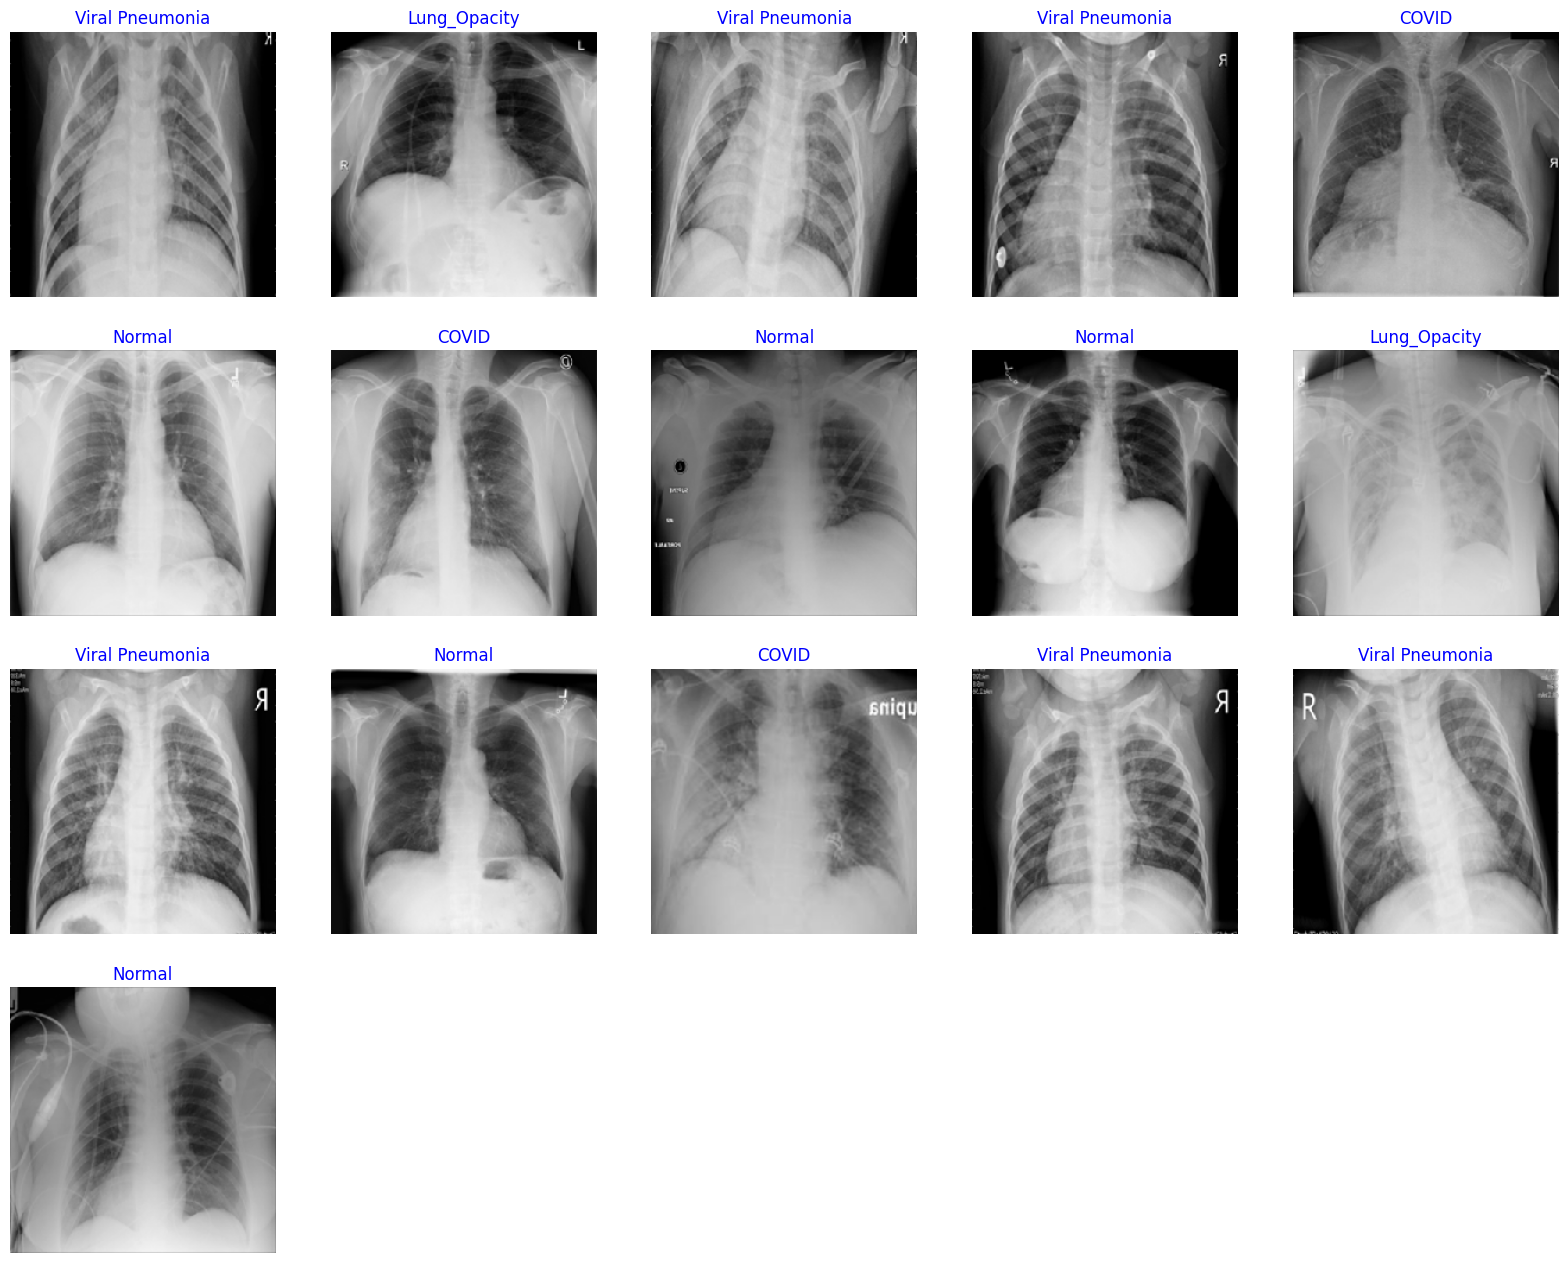

In [17]:
mostrar_imagenes(generador_entrenamiento)

modelo iception

In [18]:

# Crear la estructura del modelo
tamaño_img = (224, 224)
canales = 3
forma_img = (tamaño_img[0], tamaño_img[1], canales)
cantidad_clases = len(list(generador_entrenamiento.class_indices.keys()))  # para definir el número de clases en la capa densa

# Crear el modelo pre-entrenado (puedes construirlo sobre un modelo pre-entrenado como EfficientNet, VGG, ResNet)
modelo_base_InceptionResNetV2 = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights="imagenet", input_shape=forma_img, pooling='max')

modelo_InceptionResNetV2 = Sequential([
    modelo_base_InceptionResNetV2,
    Dense(cantidad_clases, activation='softmax')
])

modelo_InceptionResNetV2.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

modelo_InceptionResNetV2.summary()


219055592/219055592 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 dense (Dense)               (None, 4)                 6148      
                                                                 
Total params: 54,342,884
Trainable params: 54,282,340
Non-trainable params: 60,544
_________________________________________________________________


In [19]:
#parametros callback
tam_lote = 16 # tamaño del lote para el entrenamiento
epocas = 5
paciencia = 3
paciencia_para_detener = 8
umbral_entrenamiento = 0.9
factor_reduccion = 0.5
preguntar_epoca = 5
lotes_entrenados = int(np.ceil(len(generador_entrenamiento.labels) / tam_lote))

callbacks = [MiCallback(modelo=modelo_InceptionResNetV2, paciencia=paciencia, paciencia_para_detener=paciencia_para_detener, umbral=umbral_entrenamiento,
factor=factor_reduccion, lotes=lotes_entrenados, epocas=epocas, preguntar_epoca=preguntar_epoca)]

In [15]:
history_InceptionResNetV2 = modelo_InceptionResNetV2.fit(x=generador_entrenamiento, epochs=epocas, verbose=0, callbacks=callbacks, validation_data=generador_validacion, validation_steps=None, shuffle=False)

¿Deseas que el modelo te pida que detengas el entrenamiento [s/n]?
s
 Época   Pérdida  PrecisiónPérdida_VPrecisión_V   LR    Siguiente LR Monitor  % Mejora  Duración
 1 /5      1.535   64.186   2.99624  57.407   0.00100  0.00100  precisión    0.00    605.32 
 2 /5      0.668   83.488   1.97942  61.111   0.00100  0.00100  precisión   30.07   1142.34 
 3 /5      0.275   90.698   0.71491  75.926   0.00100  0.00100  val_loss    63.88   1707.53 
 4 /5      0.157   96.279   0.57046  83.333   0.00100  0.00100  val_loss    20.20   2271.50 
 5 /5      0.073   97.674   0.44476  85.185   0.00100  0.00100  val_loss    22.03   2835.24 
Ingresa H para detener el entrenamiento o un número para continuar durante un número específico de épocas y luego preguntar nuevamente
h
El entrenamiento ha sido detenido en la época 5 debido a la entrada del usuario
tiempo transcurrido durante el entrenamiento: 1.0 horas,  1.0 minutos, 49.12 segundos)


In [20]:
history_InceptionResNetV2 = modelo_InceptionResNetV2.fit(x=generador_entrenamiento, epochs=epocas, verbose=0, callbacks=callbacks, validation_data=generador_validacion, validation_steps=None, shuffle=False)

¿Deseas que el modelo te pida que detengas el entrenamiento [s/n]?
 Época   Pérdida  PrecisiónPérdida_VPrecisión_V   LR    Siguiente LR Monitor  % Mejora  Duración
 1 /5      1.630   62.791   9.47215  24.074   0.00100  0.00100  precisión    0.00    201.56 
 2 /5      0.439   84.419   6.17481  33.333   0.00100  0.00100  precisión   34.44    250.09 
 3 /5      0.322   90.698   2.61622  59.259   0.00100  0.00100  val_loss    57.63    260.30 
 4 /5      0.243   91.628   0.76534  77.778   0.00100  0.00100  val_loss    70.75    269.57 
 5 /5      0.187   95.581   1.29009  74.074   0.00100  0.00100  val_loss    -68.56   279.69 
Ingresa H para detener el entrenamiento o un número para continuar durante un número específico de épocas y luego preguntar nuevamente
h
El entrenamiento ha sido detenido en la época 5 debido a la entrada del usuario
tiempo transcurrido durante el entrenamiento: 0.0 horas, 12.0 minutos, 5.81 segundos)


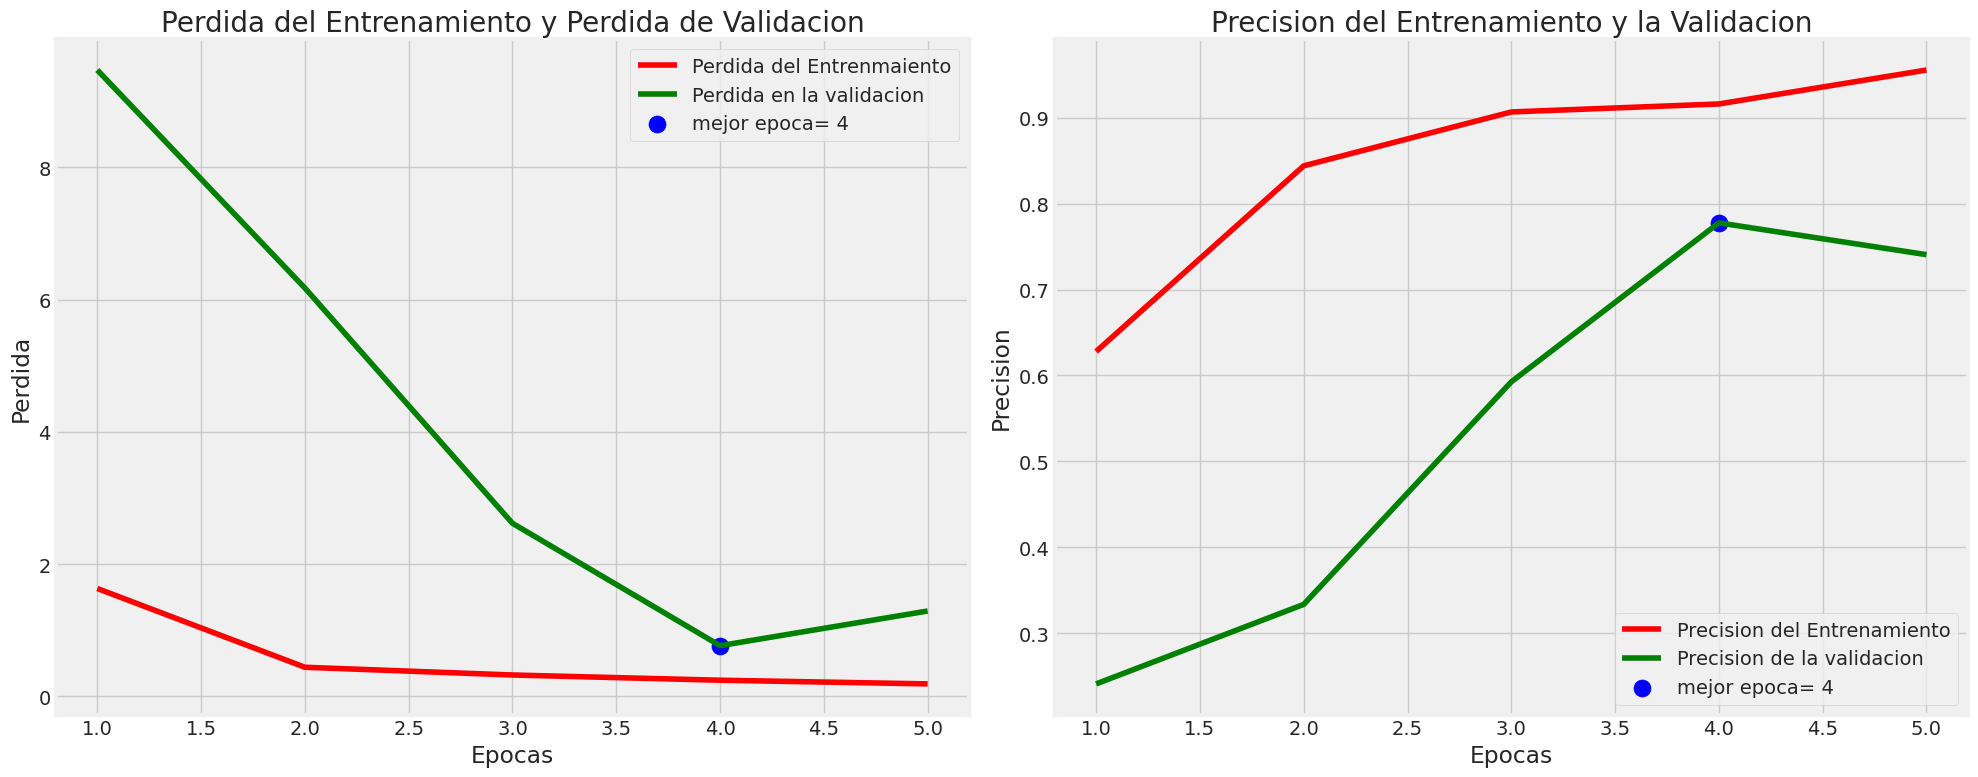

In [21]:
plot_training(history_InceptionResNetV2)

In [22]:
# Crear la estructura del modelo
tamaño_img = (331, 331)  # Tamaño de entrada requerido para NASNetLarge
canales = 3
forma_img = (tamaño_img[0], tamaño_img[1], canales)
cantidad_clases = len(list(generador_entrenamiento.class_indices.keys()))  # para definir el número de clases en la capa densa

# Crear el modelo pre-entrenado (puedes construirlo sobre un modelo pre-entrenado como EfficientNet, VGG, ResNet)
modelo_base_NASNetLarge = tf.keras.applications.NASNetLarge(include_top=False, weights="imagenet", input_shape=forma_img, pooling='max')

modelo_NASNetLarge = Sequential([
    modelo_base_NASNetLarge,
    Dense(cantidad_clases, activation='softmax')
])

modelo_NASNetLarge.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

modelo_NASNetLarge.summary()

343610240/343610240 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 4032)              84916818  
                                                                 
 dense_1 (Dense)             (None, 4)                 16132     
                                                                 
Total params: 84,932,950
Trainable params: 84,736,282
Non-trainable params: 196,668
_________________________________________________________________


In [23]:
history_NASNetLarge = modelo_NASNetLarge.fit(x=generador_entrenamiento, epochs=epocas, verbose=0, callbacks=callbacks, validation_data=generador_validacion, validation_steps=None, shuffle=False)

¿Deseas que el modelo te pida que detengas el entrenamiento [s/n]?
s
 Época   Pérdida  PrecisiónPérdida_VPrecisión_V   LR    Siguiente LR Monitor  % Mejora  Duración
 1 /5      1.485   53.256  12.67608  27.778   0.00100  0.00100  precisión    0.00    228.31 
 2 /5      0.748   65.581  35.89299  27.778   0.00100  0.00050  precisión   -31.39   249.69 
 3 /5      0.660   77.209  42.00850  27.778   0.00050  0.00050  precisión   -19.22   270.80 
 4 /5      0.549   83.256  47.78068  27.778   0.00050  0.00050  precisión   -12.90   292.10 
 5 /5      0.291   90.233  46.33223  27.778   0.00050  0.00025  val_loss   -5953.80  313.88 
Ingresa H para detener el entrenamiento o un número para continuar durante un número específico de épocas y luego preguntar nuevamente
h
El entrenamiento ha sido detenido en la época 5 debido a la entrada del usuario
tiempo transcurrido durante el entrenamiento: 0.0 horas,  9.0 minutos, 30.52 segundos)


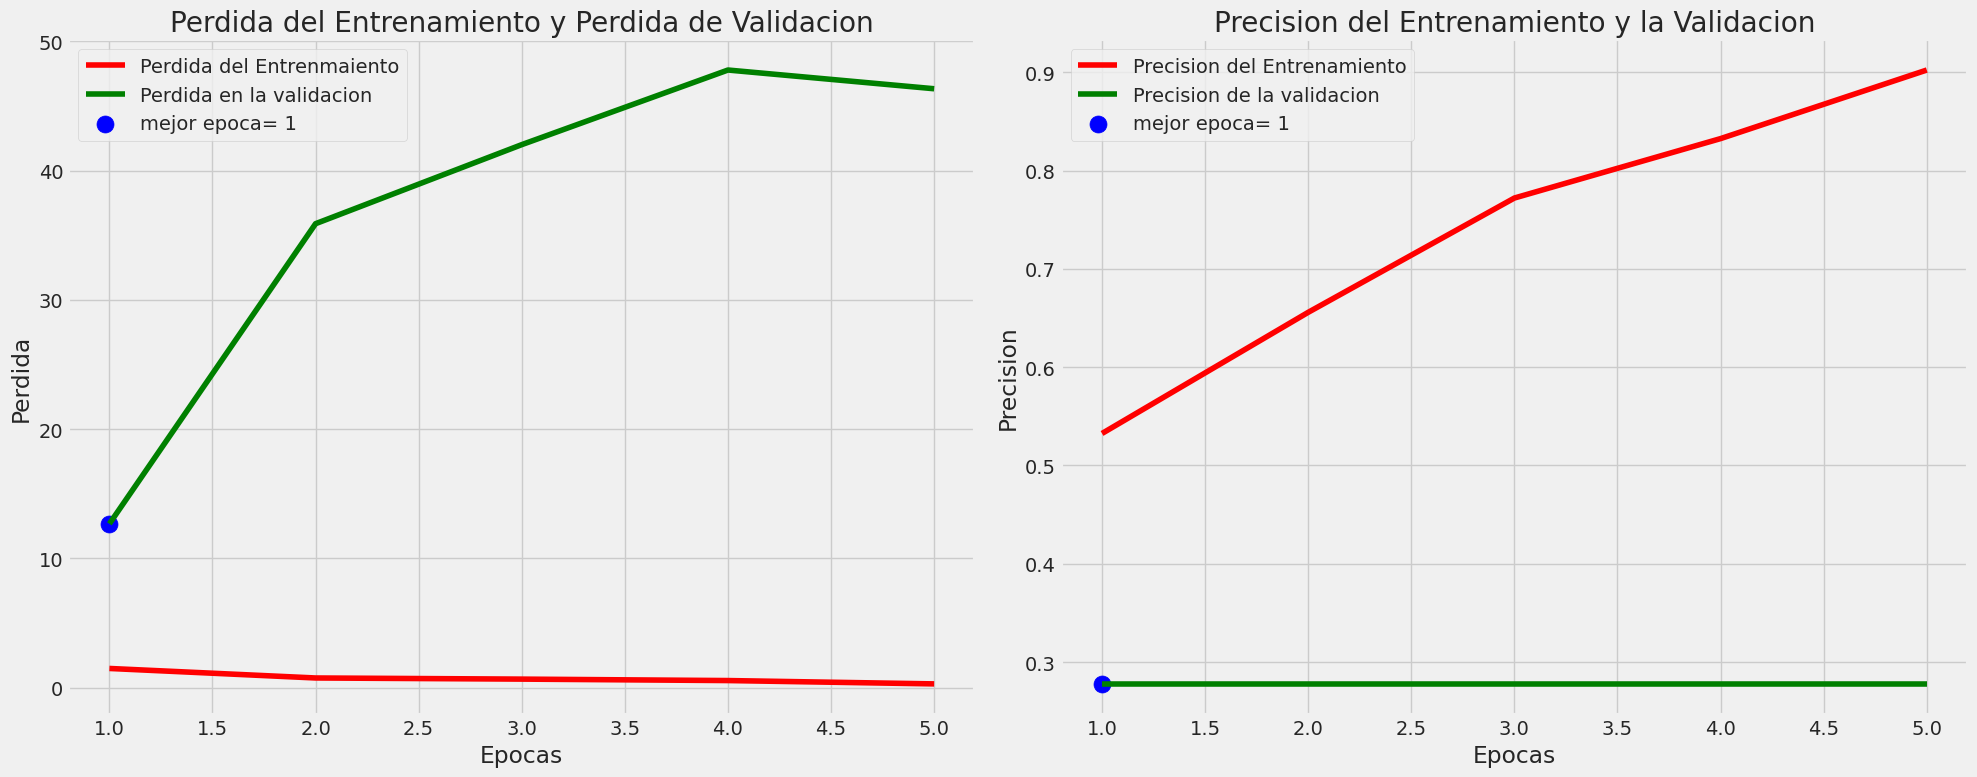

In [24]:
plot_training(history_NASNetLarge)

In [25]:
# Crear la estructura del modelo
tamaño_img = (331, 331)  # Tamaño de entrada requerido para NASNetLarge
canales = 3
forma_img = (tamaño_img[0], tamaño_img[1], canales)
cantidad_clases = len(list(generador_entrenamiento.class_indices.keys()))  # para definir el número de clases en la capa densa

# Crear el modelo pre-entrenado (puedes construirlo sobre un modelo pre-entrenado como EfficientNet, VGG, ResNet)
modelo_base_EfficientNetB0 = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=forma_img, pooling='max')

modelo_EfficientNetB0 = Sequential([
    modelo_base_EfficientNetB0,
    Dense(cantidad_clases, activation='softmax')
])

modelo_EfficientNetB0.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

modelo_EfficientNetB0.summary()


16705208/16705208 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense_2 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 4,054,695
Trainable params: 4,012,672
Non-trainable params: 42,023
_________________________________________________________________


In [26]:
history_EfficientNetB0 = modelo_EfficientNetB0.fit(x=generador_entrenamiento, epochs=epocas, verbose=0, callbacks=callbacks, validation_data=generador_validacion, validation_steps=None, shuffle=False)


¿Deseas que el modelo te pida que detengas el entrenamiento [s/n]?
s
 Época   Pérdida  PrecisiónPérdida_VPrecisión_V   LR    Siguiente LR Monitor  % Mejora  Duración
 1 /5      1.937   60.233   1.39835  57.407   0.00025  0.00025  precisión    0.00    47.55  
 2 /5      0.334   89.535   1.18458  66.667   0.00025  0.00025  precisión   -6.33    52.01  
 3 /5      0.192   95.116   1.18794  64.815   0.00025  0.00013  val_loss    -55.22   56.05  
 4 /5      0.162   93.721   1.10790  74.074   0.00013  0.00013  val_loss    -44.76   60.80  
 5 /5      0.066   97.209   1.14510  74.074   0.00013  0.00013  val_loss    -49.62   65.29  
Ingresa H para detener el entrenamiento o un número para continuar durante un número específico de épocas y luego preguntar nuevamente
h
El entrenamiento ha sido detenido en la época 5 debido a la entrada del usuario
tiempo transcurrido durante el entrenamiento: 0.0 horas,  1.0 minutos, 9.46 segundos)


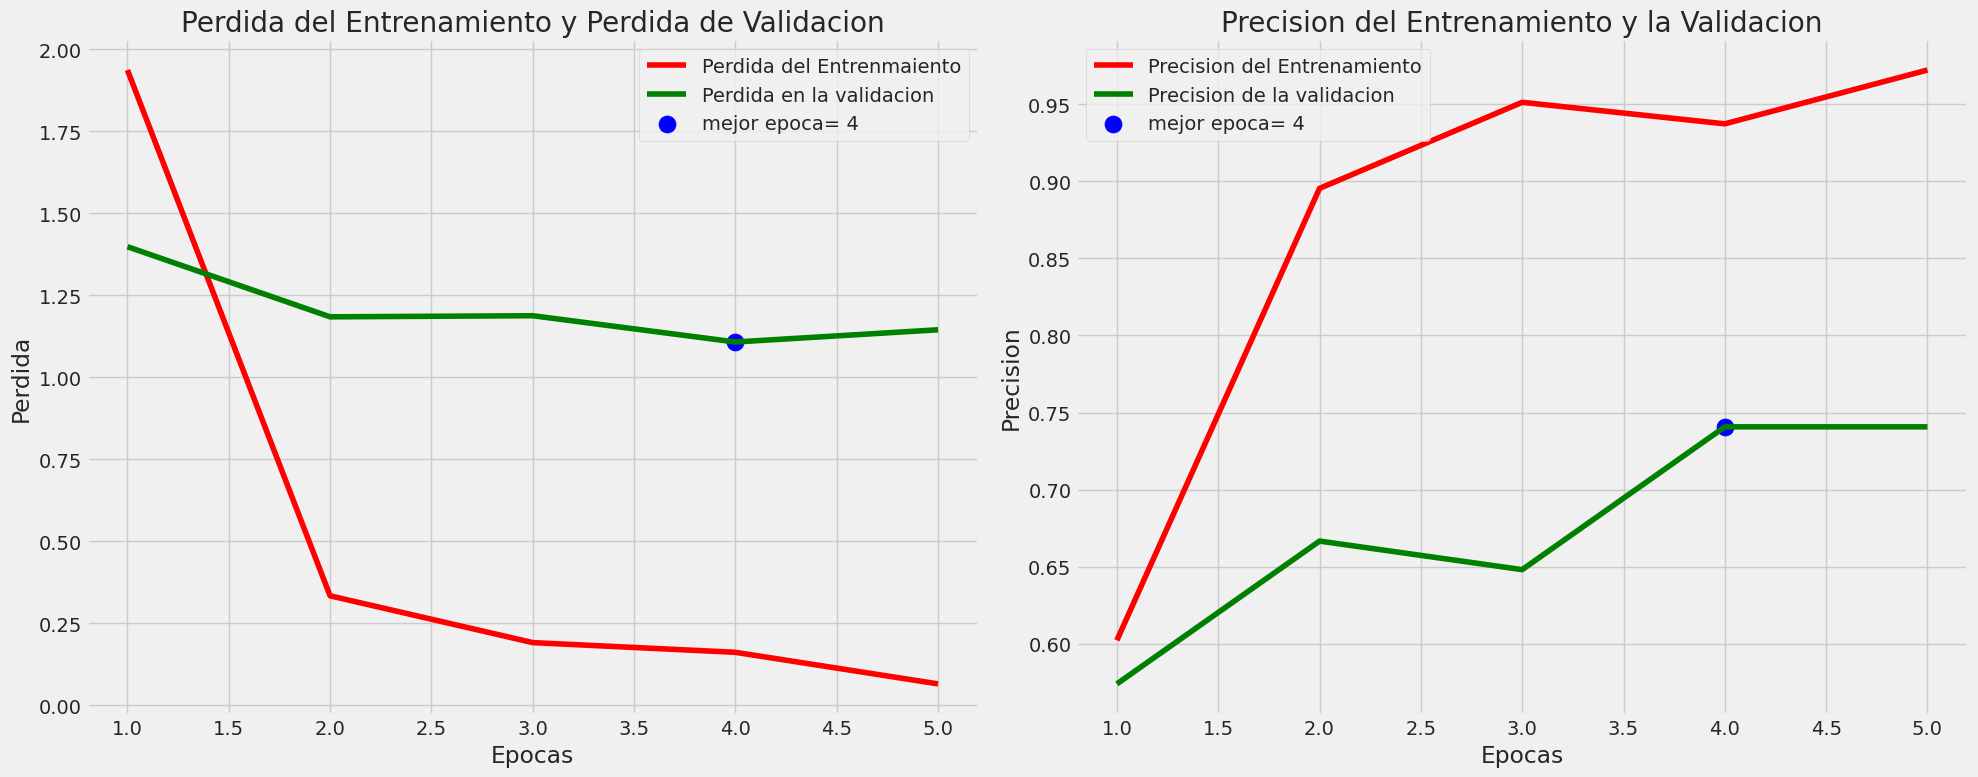

In [28]:
plot_training(history_EfficientNetB0)


In [29]:
# Crear la estructura del modelo
tamaño_img = (331, 331)  # Tamaño de entrada requerido para NASNetLarge
canales = 3
forma_img = (tamaño_img[0], tamaño_img[1], canales)
cantidad_clases = len(list(generador_entrenamiento.class_indices.keys()))  # para definir el número de clases en la capa densa

# Crear el modelo pre-entrenado (puedes construirlo sobre un modelo pre-entrenado como EfficientNet, VGG, ResNet)
modelo_base_ResNet50 = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=forma_img, pooling='max')

modelo_ResNet50 = Sequential([
    modelo_base_ResNet50,
    Dense(cantidad_clases, activation='softmax')
])

modelo_ResNet50.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

modelo_ResNet50.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_3 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 23,595,908
Trainable params: 23,542,788
Non-trainable params: 53,120
_________________________________________________________________


In [31]:
history_ResNet50 = modelo_ResNet50.fit(x=generador_entrenamiento, epochs=epocas, verbose=0, callbacks=callbacks, validation_data=generador_validacion, validation_steps=None, shuffle=False)


¿Deseas que el modelo te pida que detengas el entrenamiento [s/n]?
s
 Época   Pérdida  PrecisiónPérdida_VPrecisión_V   LR    Siguiente LR Monitor  % Mejora  Duración
 1 /5      4.252   64.419  167.15941 25.926   0.00013  0.00006  precisión    0.00    46.86  
 2 /5      1.541   83.488  31.77121  29.630   0.00006  0.00006  precisión   -14.11   52.31  
 3 /5      1.604   85.814   7.49123  62.963   0.00006  0.00006  precisión   -11.72   57.64  
 4 /5      0.814   91.163   5.31202  61.111   0.00006  0.00003  val_loss   -594.07   63.06  
 5 /5      0.399   93.953   8.06753  66.667   0.00003  0.00003  val_loss   -954.11   73.14  
Ingresa H para detener el entrenamiento o un número para continuar durante un número específico de épocas y luego preguntar nuevamente
h
El entrenamiento ha sido detenido en la época 5 debido a la entrada del usuario
tiempo transcurrido durante el entrenamiento: 0.0 horas,  3.0 minutos, 9.63 segundos)


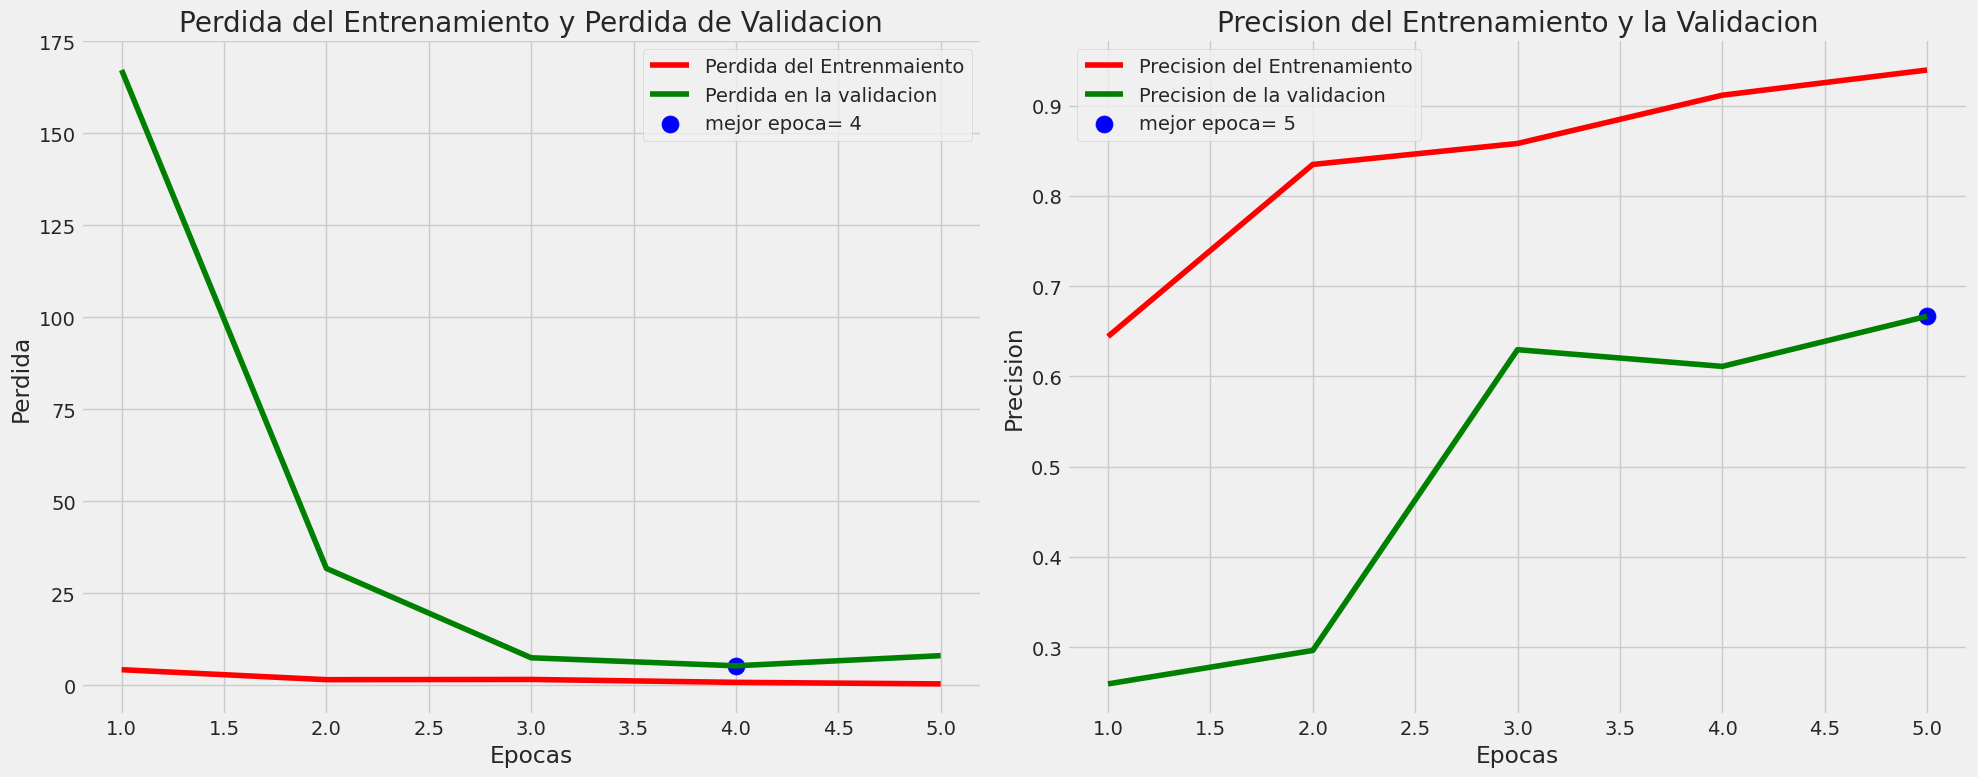

In [33]:
plot_training(history_ResNet50)

In [34]:
# Crear la estructura del modelo
tamaño_img = (331, 331)  # Tamaño de entrada requerido para NASNetLarge
canales = 3
forma_img = (tamaño_img[0], tamaño_img[1], canales)
cantidad_clases = len(list(generador_entrenamiento.class_indices.keys()))  # para definir el número de clases en la capa densa

# Crear el modelo pre-entrenado (puedes construirlo sobre un modelo pre-entrenado como EfficientNet, VGG, ResNet)
modelo_base_ResNet101 = tf.keras.applications.ResNet101(include_top=False, weights="imagenet", input_shape=forma_img, pooling='max')

modelo_ResNet101 = Sequential([
    modelo_base_ResNet101,
    Dense(cantidad_clases, activation='softmax')
])

modelo_ResNet101.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

modelo_ResNet101.summary()

171446536/171446536 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 2048)              42658176  
                                                                 
 dense_4 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 42,666,372
Trainable params: 42,561,028
Non-trainable params: 105,344
_________________________________________________________________


In [35]:
history_ResNet101 = modelo_ResNet101.fit(x=generador_entrenamiento, epochs=epocas, verbose=0, callbacks=callbacks, validation_data=generador_validacion, validation_steps=None, shuffle=False)


¿Deseas que el modelo te pida que detengas el entrenamiento [s/n]?
s
 Época   Pérdida  PrecisiónPérdida_VPrecisión_V   LR    Siguiente LR Monitor  % Mejora  Duración
 1 /5      6.123   63.721  11.20364  22.222   0.00003  0.00003  precisión    0.00    79.80  
 2 /5      2.792   75.581  61.05410  27.778   0.00003  0.00002  precisión   -22.25   88.59  
 3 /5      1.588   81.163  13.19272  14.815   0.00002  0.00002  precisión   -16.51   97.47  
 4 /5      1.380   83.721  26.74405  44.444   0.00002  0.00002  precisión   -13.88   106.27 
 5 /5      0.616   88.837  29.38692  50.000   0.00002  0.00001  precisión   -8.61    116.35 
Ingresa H para detener el entrenamiento o un número para continuar durante un número específico de épocas y luego preguntar nuevamente
h
El entrenamiento ha sido detenido en la época 5 debido a la entrada del usuario
tiempo transcurrido durante el entrenamiento: 0.0 horas,  2.0 minutos, 12.71 segundos)


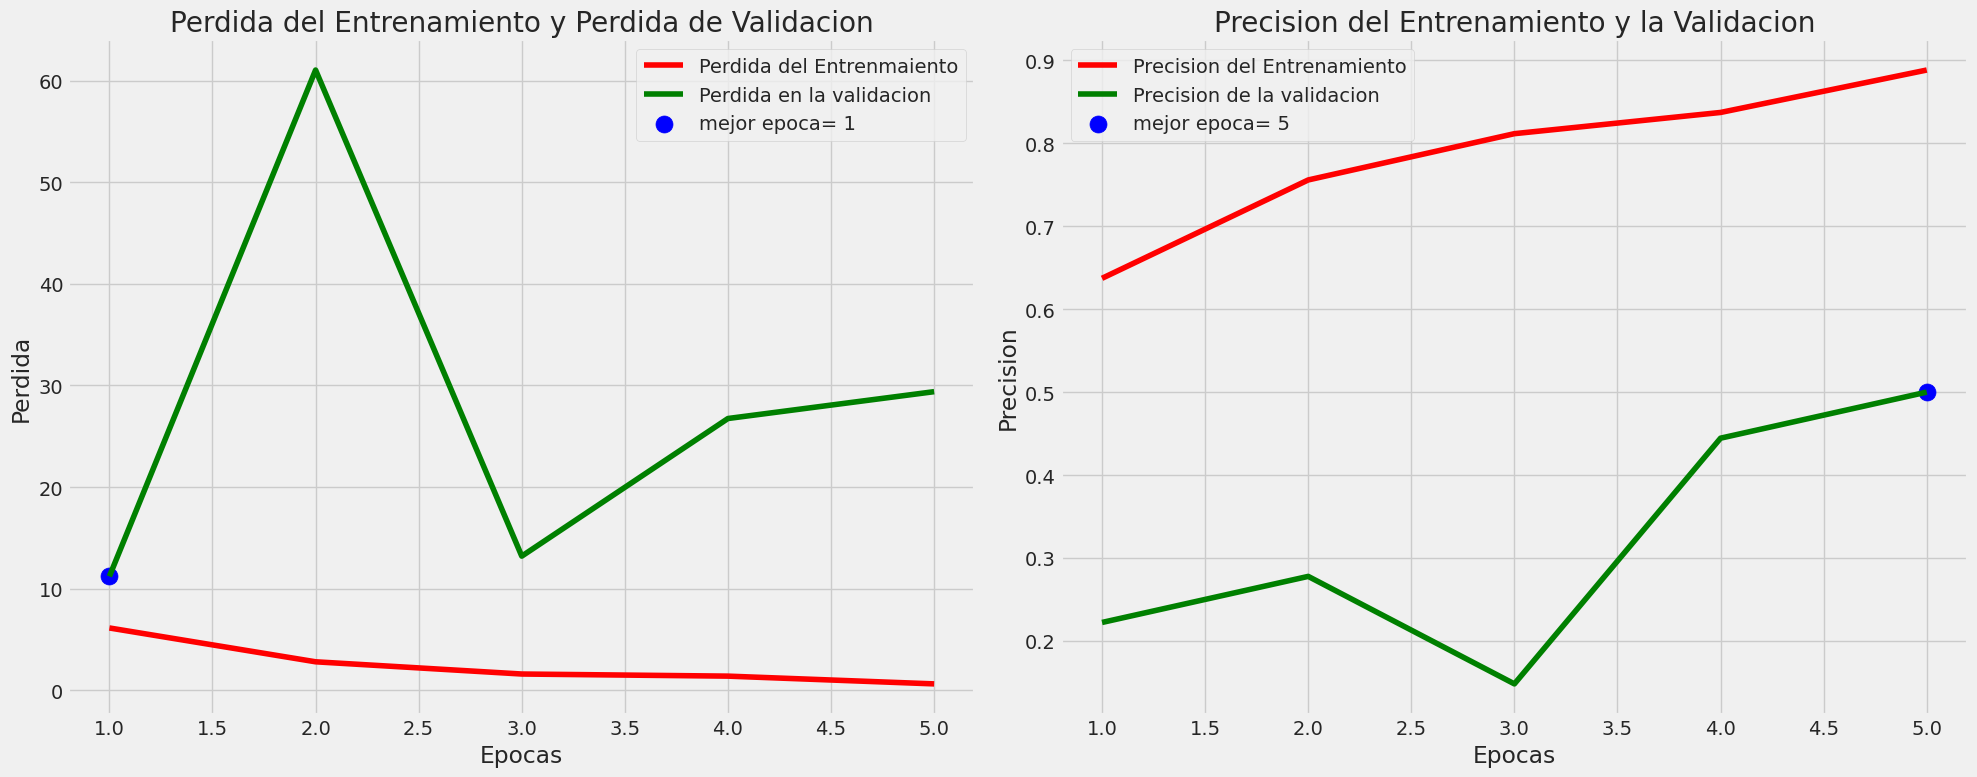

In [36]:
plot_training(history_ResNet101)

**MODELO VGG19**

In [ ]:
# Crear la estructura del modelo
tamaño_img = (224, 224)
canales = 3
forma_img = (tamaño_img[0], tamaño_img[1], canales)
cantidad_clases = len(list(generador_entrenamiento.class_indices.keys()))  # para definir el número de clases en la capa densa

# Crear el modelo pre-entrenado (puedes construirlo sobre un modelo pre-entrenado como EfficientNet, VGG, ResNet)
# En este caso, utilizaremos VGG19 como modelo base.
modelo_base_VGG19 = tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=forma_img, pooling='max')

modelo_VGG19 = Sequential([
    modelo_base_VGG19,
    Dense(cantidad_clases, activation='softmax')
])

modelo_VGG19.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

modelo_VGG19.summary()


80134624/80134624 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense (Dense)               (None, 4)                 2052      
                                                                 
Total params: 20,026,436
Trainable params: 20,026,436
Non-trainable params: 0
_________________________________________________________________


**MODELO DENSENET169**

In [ ]:
# Crear la estructura del modelo
tamaño_img = (224, 224)
canales = 3
forma_img = (tamaño_img[0], tamaño_img[1], canales)
cantidad_clases = len(list(generador_entrenamiento.class_indices.keys()))  # para definir el número de clases en la capa densa

# Crear el modelo pre-entrenado (puedes construirlo sobre un modelo pre-entrenado como EfficientNet, VGG, ResNet)
modelo_base_DenseNet169 = tf.keras.applications.densenet.DenseNet169(include_top=False, weights="imagenet", input_shape=forma_img, pooling='max')

modelo_DenseNet169 = Sequential([
    modelo_base_DenseNet169,
    Dense(cantidad_clases, activation='softmax')
])

modelo_DenseNet169.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

modelo_DenseNet169.summary()


51877672/51877672 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 1664)              12642880  
                                                                 
 dense_1 (Dense)             (None, 4)                 6660      
                                                                 
Total params: 12,649,540
Trainable params: 12,491,140
Non-trainable params: 158,400
_________________________________________________________________


ENTRENAMIENTO DEL MODELO VGG19

In [ ]:
#parametros callback
tam_lote = 16 # tamaño del lote para el entrenamiento
epocas = 20
paciencia = 3
paciencia_para_detener = 8
umbral_entrenamiento = 0.9
factor_reduccion = 0.5
preguntar_epoca = 5
lotes_entrenados = int(np.ceil(len(generador_entrenamiento.labels) / tam_lote))

callbacks = [MiCallback(modelo=modelo_VGG19, paciencia=paciencia, paciencia_para_detener=paciencia_para_detener, umbral=umbral_entrenamiento,
factor=factor_reduccion, lotes=lotes_entrenados, epocas=epocas, preguntar_epoca=preguntar_epoca)]

In [ ]:
history_VGG19 = modelo_VGG19.fit(x=generador_entrenamiento, epochs=epocas, verbose=0, callbacks=callbacks, validation_data=generador_validacion, validation_steps=None, shuffle=False)

¿Deseas que el modelo te pida que detengas el entrenamiento [s/n]?
 Época   Pérdida  PrecisiónPérdida_VPrecisión_V   LR    Siguiente LR Monitor  % Mejora  Duración
 1 /20    37.860   26.047   1.38098  25.926   0.00100  0.00100  precisión    0.00   1321.17 
 2 /20     1.379   33.721   1.38584  22.222   0.00100  0.00100  precisión   29.46   2601.74 
 3 /20     1.338   35.116   1.32094  42.593   0.00100  0.00100  precisión    4.14   3917.66 
 4 /20     1.306   38.372   1.29138  42.593   0.00100  0.00100  precisión    9.27   5219.78 
 5 /20     1.271   39.535   1.19040  51.852   0.00100  0.00100  precisión    3.03   6466.86 
Ingresa H para detener el entrenamiento o un número para continuar durante un número específico de épocas y luego preguntar nuevamente
h
El entrenamiento ha sido detenido en la época 5 debido a la entrada del usuario
tiempo transcurrido durante el entrenamiento: 1.0 horas, 49.0 minutos, 38.80 segundos)


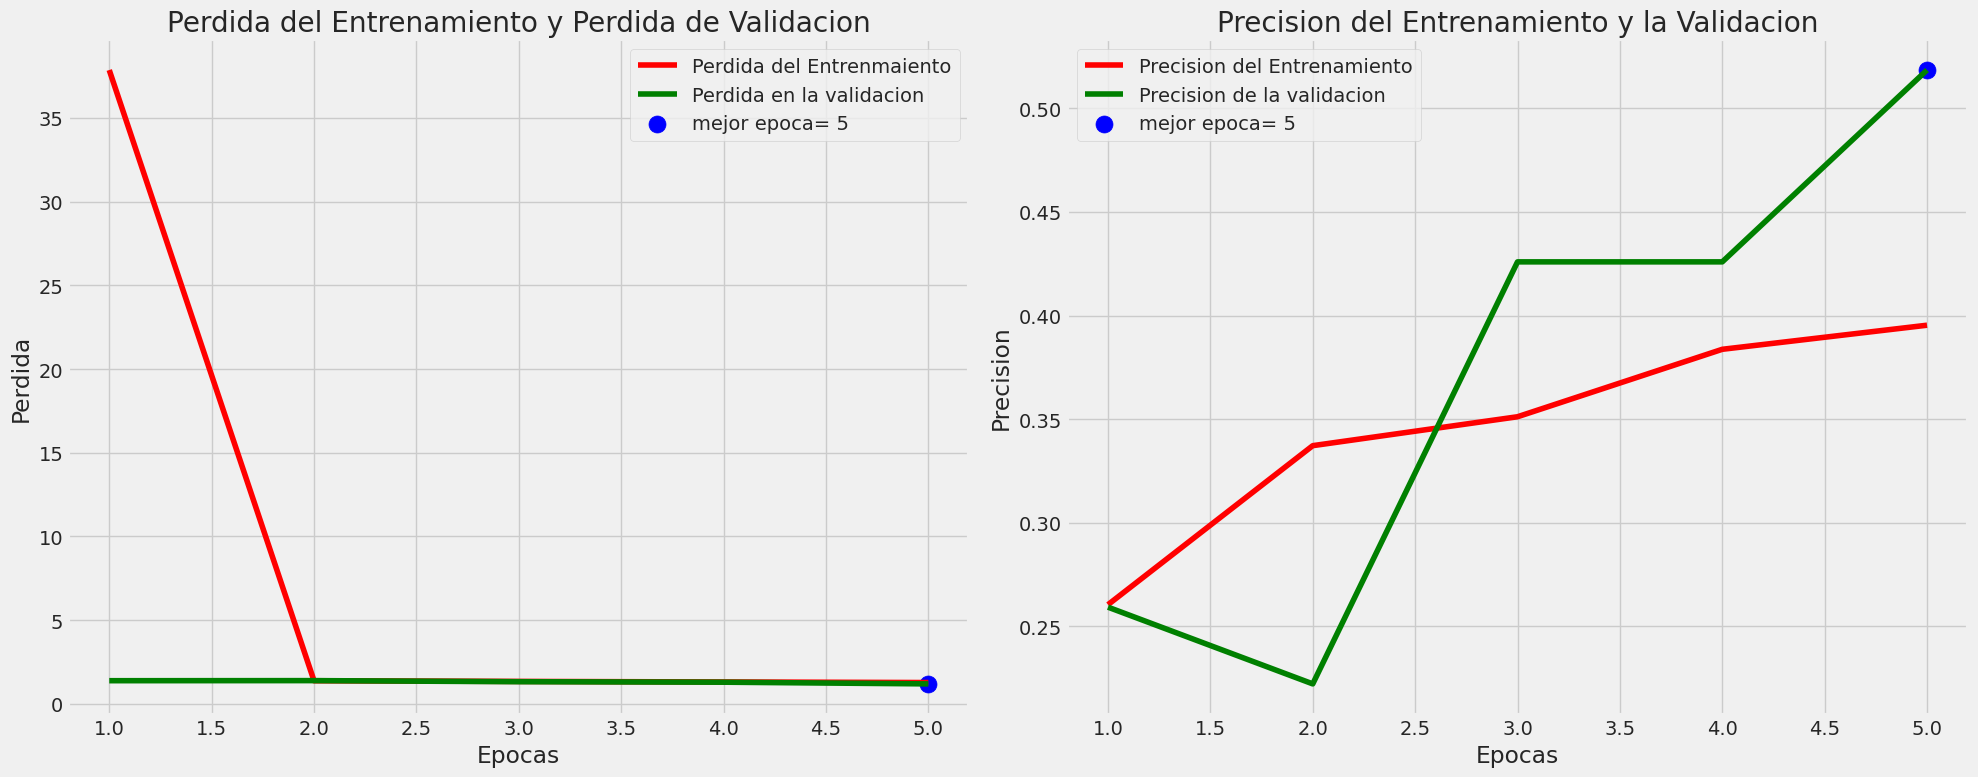

In [ ]:
plot_training(history_VGG19)

In [ ]:
history_DenseNet169 = modelo_DenseNet169.fit(x=generador_entrenamiento, epochs=epocas, verbose=0, callbacks=callbacks, validation_data=generador_validacion, validation_steps=None, shuffle=False)

¿Deseas que el modelo te pida que detengas el entrenamiento [s/n]?
 Época   Pérdida  PrecisiónPérdida_VPrecisión_V   LR    Siguiente LR Monitor  % Mejora  Duración
 1 /20     0.142   96.512   0.49210  88.889   0.00100  0.00100  val_loss     0.00    441.12 
 2 /20     0.167   95.581   0.80557  81.481   0.00100  0.00100  val_loss   -131.65   878.30 
 3 /20     0.106   96.279   1.17938  83.333   0.00100  0.00050  val_loss   -239.15  1318.20 
 4 /20     0.057   98.140   0.71769  85.185   0.00050  0.00050  val_loss   -106.38  1760.63 
 5 /20     0.100   97.907   0.44416  87.037   0.00050  0.00050  val_loss    -27.72  2206.19 
Ingresa H para detener el entrenamiento o un número para continuar durante un número específico de épocas y luego preguntar nuevamente
El entrenamiento ha sido detenido en la época 5 debido a la entrada del usuario
 6 /20     0.056   98.372   0.36021  90.741   0.00050  0.00025  val_loss    -3.58   2696.83 
Ingresa H para detener el entrenamiento o un número para contin

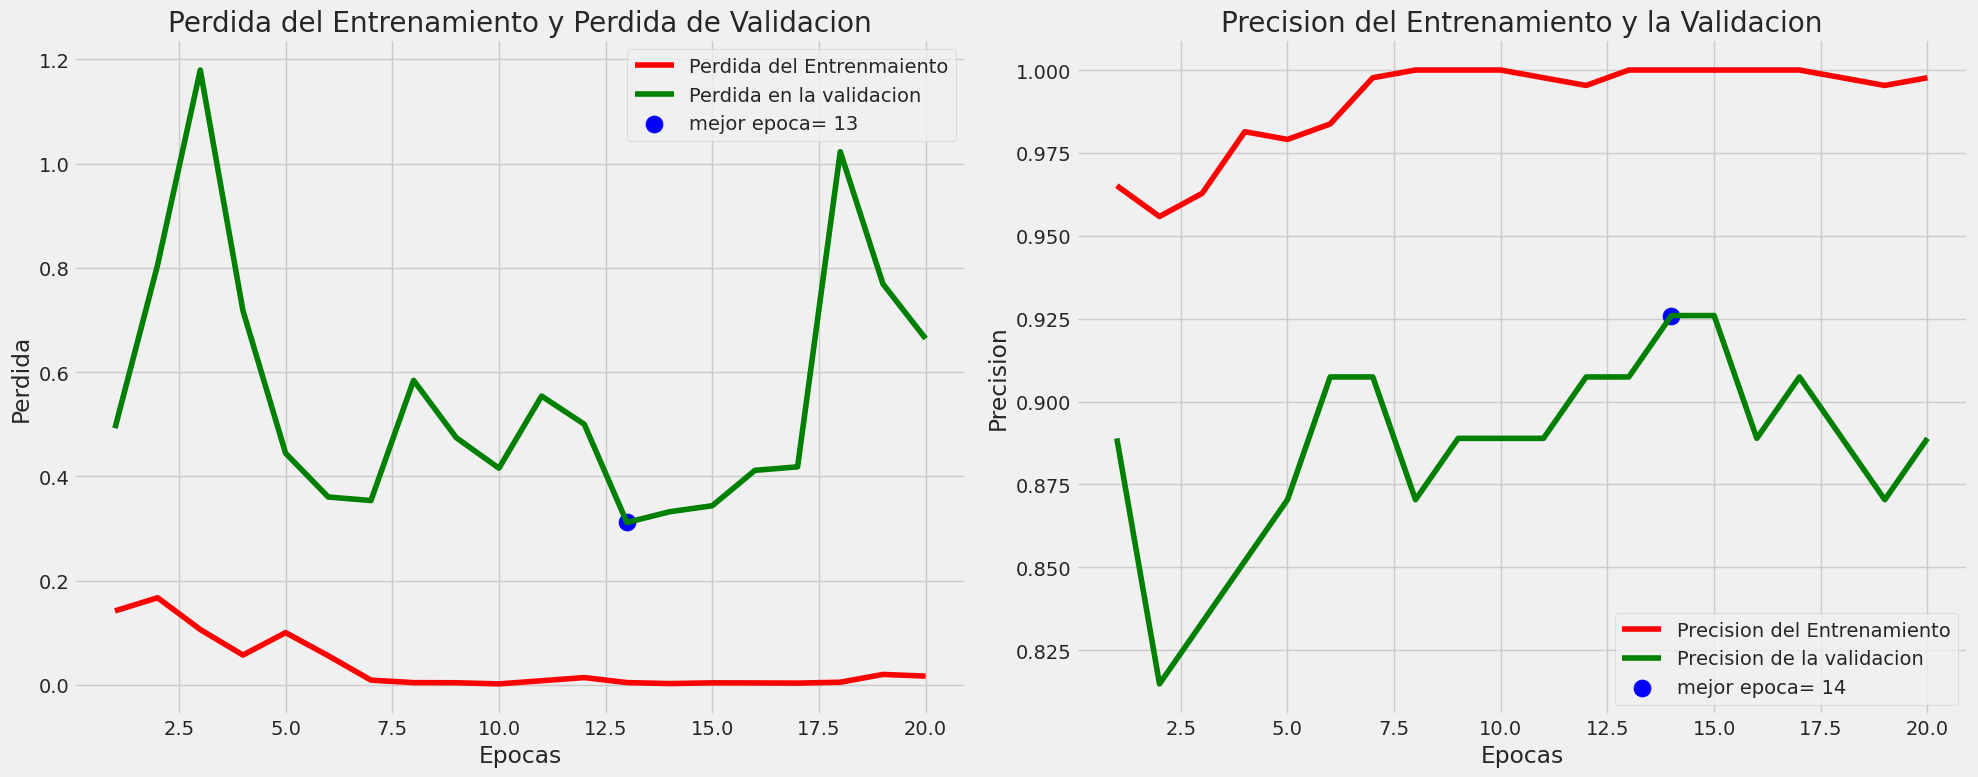

In [ ]:
plot_training(history_DenseNet169)

In [ ]:
ts_length = len(df_prueba)  # longitud del conjunto de datos de prueba
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
# tamaño del lote para el conjunto de datos de prueba
test_steps = ts_length // test_batch_size  # número de pasos para ejecutar el conjunto de datos de prueba en el modelo

train_score = modelo_VGG19.evaluate(generador_entrenamiento, steps=test_steps, verbose=1)  # evaluar el modelo en el conjunto de datos de entrenamiento
valid_score = modelo_VGG19.evaluate(generador_entrenamiento, steps=test_steps, verbose=1)  # evaluar el modelo en el conjunto de datos de validación
test_score = modelo_VGG19.evaluate(generador_entrenamiento, steps=test_steps, verbose=1)  # evaluar el modelo en el conjunto de datos de prueba

print("Pérdida en entrenamiento: ", train_score[0])  # mostrar la pérdida en el conjunto de datos de entrenamiento
print("Precisión en entrenamiento: ", train_score[1])  # mostrar la precisión en el conjunto de datos de entrenamiento
print('-' * 20)
print("Pérdida en validación: ", valid_score[0])  # mostrar la pérdida en el conjunto de datos de validación
print("Precisión en validación: ", valid_score[1])  # mostrar la precisión en el conjunto de datos de validación
print('-' * 20)
print("Pérdida en prueba: ", test_score[0])  # mostrar la pérdida en el conjunto de datos de prueba
print("Precisión en prueba: ", test_score[1])  # mostrar la precisión en el conjunto de datos de prueba


1/1 [==============================] - 12s 12s/step - loss: 1.2429 - accuracy: 0.3750
Pérdida en entrenamiento:  1.2025446891784668
Precisión en entrenamiento:  0.375
--------------------
Pérdida en validación:  1.309180498123169
Precisión en validación:  0.3125
--------------------
Pérdida en prueba:  1.2429237365722656
Precisión en prueba:  0.375


In [ ]:
ts_length = len(df_prueba)  # longitud del conjunto de datos de prueba
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
# tamaño del lote para el conjunto de datos de prueba
test_steps = ts_length // test_batch_size  # número de pasos para ejecutar el conjunto de datos de prueba en el modelo

train_score = modelo_DenseNet169.evaluate(generador_entrenamiento, steps=test_steps, verbose=1)  # evaluar el modelo en el conjunto de datos de entrenamiento
valid_score = modelo_DenseNet169.evaluate(generador_entrenamiento, steps=test_steps, verbose=1)  # evaluar el modelo en el conjunto de datos de validación
test_score = modelo_DenseNet169.evaluate(generador_entrenamiento, steps=test_steps, verbose=1)  # evaluar el modelo en el conjunto de datos de prueba

print("Pérdida en entrenamiento: ", train_score[0])  # mostrar la pérdida en el conjunto de datos de entrenamiento
print("Precisión en entrenamiento: ", train_score[1])  # mostrar la precisión en el conjunto de datos de entrenamiento
print('-' * 20)
print("Pérdida en validación: ", valid_score[0])  # mostrar la pérdida en el conjunto de datos de validación
print("Precisión en validación: ", valid_score[1])  # mostrar la precisión en el conjunto de datos de validación
print('-' * 20)
print("Pérdida en prueba: ", test_score[0])  # mostrar la pérdida en el conjunto de datos de prueba
print("Precisión en prueba: ", test_score[1])  # mostrar la precisión en el conjunto de datos de prueba


1/1 [==============================] - 0s 183ms/step - loss: 5.2329 - accuracy: 0.2500
Pérdida en entrenamiento:  4.921971321105957
Precisión en entrenamiento:  0.4375
--------------------
Pérdida en validación:  5.357039451599121
Precisión en validación:  0.25
--------------------
Pérdida en prueba:  5.232929706573486
Precisión en prueba:  0.25


In [ ]:
# Obtén las predicciones del modelo en el generador de datos de prueba
preds_VGG19 = modelo_VGG19.predict(generador_prueba)
y_pred_VGG19 = np.argmax(preds_VGG19, axis=1)  # Obtén las clases predichas (índice con mayor probabilidad) a partir de las predicciones
print(y_pred_VGG19)  # Imprimir las clases predichas

1/1 [==============================] - 0s 84ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
# Obtén las predicciones del modelo en el generador de datos de prueba
preds_DenseNet169 = modelo_DenseNet169.predict(generador_prueba)
y_pred_DenseNet169 = np.argmax(preds_DenseNet169, axis=1)  # Obtén las clases predichas (índice con mayor probabilidad) a partir de las predicciones
print(y_pred_DenseNet169)  # Imprimir las clases predichas

1/1 [==============================] - 0s 96ms/step
[3 0 0 2 2 2 0 2 2 2 2 2 0 2]


Matriz de Confusión, Sin Normalizar
[[4 0 0 0]
 [4 0 0 0]
 [3 0 0 0]
 [3 0 0 0]]
Reporte de Clasificación para VGG19:
                 precision    recall  f1-score   support

          COVID       0.29      1.00      0.44         4
   Lung_Opacity       0.00      0.00      0.00         4
         Normal       0.00      0.00      0.00         3
Viral Pneumonia       0.00      0.00      0.00         3

       accuracy                           0.29        14
      macro avg       0.07      0.25      0.11        14
   weighted avg       0.08      0.29      0.13        14

Matriz de Confusión, Sin Normalizar
[[2 0 2 0]
 [0 0 4 0]
 [0 0 3 0]
 [2 0 0 1]]
Reporte de Clasificación para DenseNet169:
                 precision    recall  f1-score   support

          COVID       0.50      0.50      0.50         4
   Lung_Opacity       0.00      0.00      0.00         4
         Normal       0.33      1.00      0.50         3
Viral Pneumonia       1.00      0.33      0.50         3

       accur

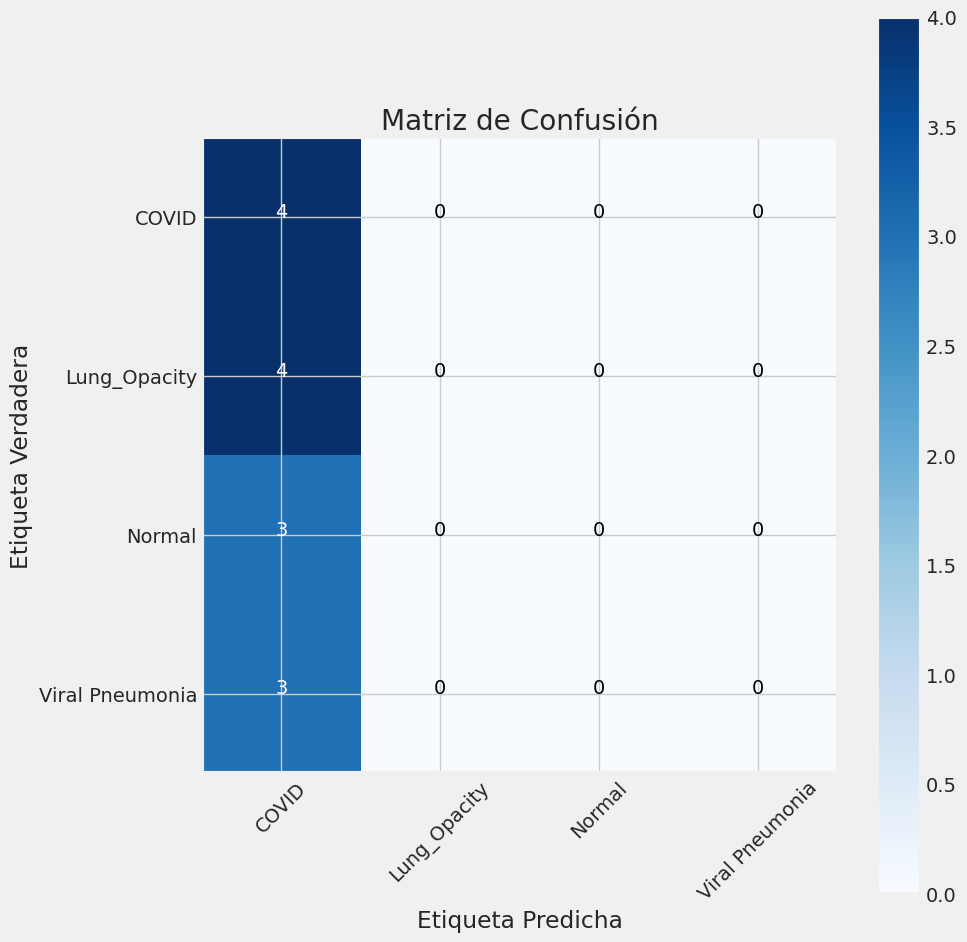

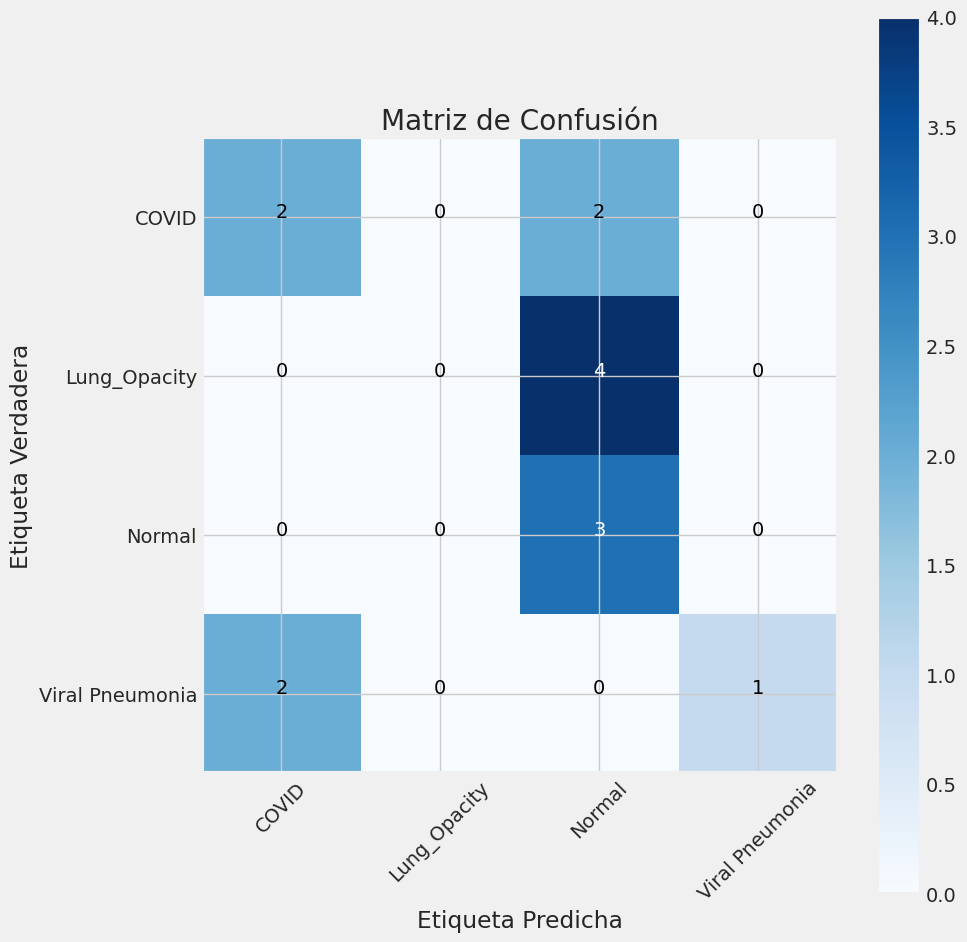

In [ ]:
g_diccionario = generador_prueba.class_indices  # obtener el diccionario de índices de clases del generador de datos de prueba
clases = list(g_diccionario.keys())  # obtener la lista de nombres de clases a partir de las claves del diccionario

# Matriz de confusión
cm_VGG19 = confusion_matrix(generador_prueba.classes, y_pred_VGG19)  # calcular la matriz de confusión utilizando las clases reales y las clases predichas
trazar_matriz_confusion(matriz_confusion=cm_VGG19, clases=clases, titulo='Matriz de Confusión VGG-19')  # graficar la matriz de confusión

# Reporte de clasificación
print("Reporte de Clasificación para VGG19:")
print(classification_report(generador_prueba.classes, y_pred_VGG19, target_names=clases))  # imprimir el reporte de clasificación que incluye precision, recall, F1-score, y soporte para cada clase


# Matriz de confusión
cm_dense169 = confusion_matrix(generador_prueba.classes, y_pred_DenseNet169)  # calcular la matriz de confusión utilizando las clases reales y las clases predichas
trazar_matriz_confusion(matriz_confusion=cm_dense169, clases=clases, titulo='Matriz de Confusión DenseNet-169')  # graficar la matriz de confusión

# Reporte de clasificación
print("Reporte de Clasificación para DenseNet169:")
print(classification_report(generador_prueba.classes, y_pred_DenseNet169, target_names=clases))
